In [2]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [3]:
df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data

# Exploratory Data Analysis (EDA)

### Step 1: Let' s take a look at the data

In [4]:
df.sample(5)

,Name,URL
11996,JAVA,https://raw.githubusercontent.com/spring-proje...
6703,PYTHON,https://raw.githubusercontent.com/django/djang...
19575,RUBY,https://raw.githubusercontent.com/rails/rails/...
4503,PYTHON,https://raw.githubusercontent.com/django/djang...
5701,PYTHON,https://raw.githubusercontent.com/django/djang...


### Step 2: Number of Unique Values in all the columns

In [5]:
df.nunique()

Name        5
URL     21054
dtype: int64

### Step 3: Unique Values in 'Name Column' (Going to be made the target variable)

In [6]:
df['Name'].unique()

array(['GAP', 'PYTHON', 'JAVA', 'PHP', 'RUBY'], dtype=object)

### Step 4: Duplicate Check for "URL" column (as this column should only have unique urls)

In [9]:
df['URL'].duplicated().sum()

0

### Step 5: Check the info() on the features

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21054 entries, 0 to 21053
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    21054 non-null  object
 1   URL     21054 non-null  object
dtypes: object(2)
memory usage: 329.1+ KB


#### conclusion drawn from Step 5:
- both columns are of type 'object'

### Step 6: Check Class Distribution 

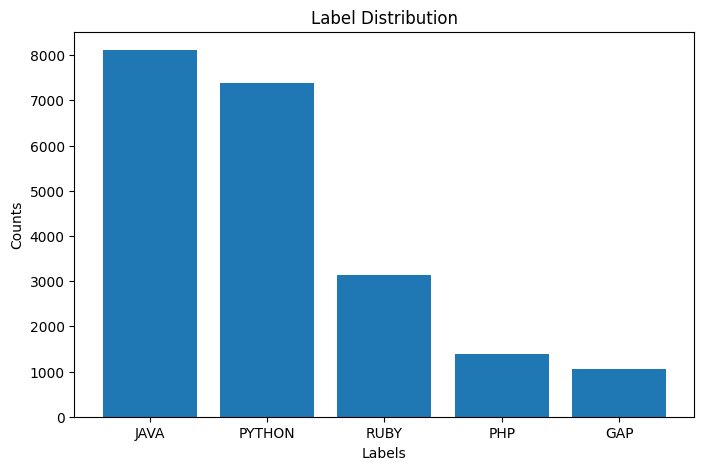

In [30]:
# Get the counts of unique labels within a column
label_counts = df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
# plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

# Custom Transformer classes (So that sklearn's pipeline can be used)

In [31]:
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
import chardet # an ML model, It uses machine learning to detect the encoding of a file

# Custom transformer for case-folding
class CaseFoldingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [x.lower() for x in X]

# Custom transformer for stop words removal
class StopWordsRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        stop_words_list = stopwords.words('english')
        return [' '.join([word for word in x.split() if word not in stop_words_list]) for x in X]
    
    # Custom transformer to remove numbers from text
class NumberRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Remove numbers using regular expression
        return [re.sub(r'\d+', '', text) for text in X]
    
class UrlToContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for url in X:
            response = requests.get(url)
            content = response.content
            encoding = chardet.detect(content)
            if encoding['encoding'] == "ISO-8859-1":
                transformed_X.append(content.decode("iso-8859-1"))
            else:
                transformed_X.append(content.decode("utf-8"))
        return transformed_X

        
# Define the preprocessing steps
preprocessing_steps = [
#     ('case_folding', CaseFoldingTransformer()),
#     ('stop_words_removal', StopWordsRemovalTransformer()),
    ('url_to_content', UrlToContentTransformer()),
    ('number_removal', NumberRemovalTransformer()),
]

# Bag-of-Words (NLP technique)

In [32]:
# Bag-of-words can be implemented using "CountVectorizer" in sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Make a preprocessing Pipeline

In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessing', Pipeline(steps=preprocessing_steps)),
    ('vectorizer', CountVectorizer(max_features=3000))
])

### Apply the preprocessing pipeline to the dataset

In [ ]:
df['Content'] = pipeline['preprocessing'].fit_transform(df['URL'])

### Visualise the datset after the preprocessing pipeline

In [ ]:
df['Content']

# Split the dataset into Independent and target variables

In [ ]:
X = df['Content']
y = df['Name']

### Better naming convention

In [ ]:
X_train = X
y_train = y

# Apply the Bag-of-Words

In [ ]:
X_train_bow = pipeline['vectorizer'].fit_transform(X_train)

#### check the length of the feature vectors

In [ ]:
len( pipeline['vectorizer'].get_feature_names_out()) 

#### Display the feature vectors

In [ ]:
pipeline['vectorizer'].get_feature_names_out()

# Train the classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train_bow, y_train)

In [ ]:
import os

print(os.getcwd())
print(os.path.dirname(os.getcwd()))

# Save the model

In [ ]:
import pickle

# Full pipeline with preprocessing and classifier
full_pipeline = Pipeline([
    ('full_preprocessing', pipeline),
    ('classifier', clf)
])

# Save the full_pipeline object
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
os.makedirs(clf_folder_path, exist_ok=True)
clf_file_path = os.path.join(clf_folder_path, 'classifier.pkl')

with open(clf_file_path, 'wb') as f:
    pickle.dump(full_pipeline, f)


# Load the saved model and see whther working or not

In [ ]:
import joblib

# Load the saved pipeline
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
clf_file_path = os.path.join(clf_folder_path, 'classifier.pkl')
loaded_pipeline = joblib.load(clf_file_path)

# Use the loaded pipeline for predictions or other operations
predictions = loaded_pipeline.predict(['https://raw.githubusercontent.com/opencv/opencv/3aeaa3402389fc55e53fbc6f5741ca29f51032ee/modules/core/misc/java/src/java/core%2BMat.java'])

In [ ]:
predictions